In [350]:
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

In [356]:
class KArmedTestBed():
    def __init__(self, k: int):
        if not (k > 0 and isinstance(k, int)):
            raise ValueError('k must be a positive integer!')
        self.__k: int = k
        self.__reward_means: np.ndarray = self.__generate_reward_means()

    @property
    def k(self):    
        return self.__k

    def __generate_reward_means(self):
        """Generate a set of k reward means from the unit normal dist.
        
            Returns:
                float: self.__k draws from the unit normal dist.
        """
        return scipy.stats.norm(loc=0, scale=1).rvs(self.__k)


    def take_action(self, action_idx: int):
        """Take one of k actions, return the reward obtained.
        
            Rewards are drawn from unit-variance normal distributions
            with means self.__reward_means.

            Note that action_idx is 0-based indexing, in accordance with
            Python's conventions, but we will denote "Action 1" the action
            corresponding to action_idx = 0.

            Parameters:
                action_idx (int): the action to be taken.

            Returns
                float: reward obtained by taking the input action.
        """
        if (action_idx < 0) or (action_idx > self.k - 1) or (not isinstance(action_idx, int)):
            print(f'self.k - 1 : {self.k-1}')
            print(f'type(action_idx) : {type(action_idx)}')
            raise ValueError(f'Action {action_idx} is not a valid action!')
        return scipy.stats.norm(loc=self.__reward_means[action_idx], scale=1).rvs(1).item()


    def plot_reward_dists(self, ax: matplotlib.axes.Axes):
        # _, ax = plt.subplots()
        for idx, rw in enumerate(self.__reward_means):
            y_p = scipy.stats.norm(loc=rw, scale=1.).rvs(200)
            parts = ax.violinplot(
                y_p, 
                positions=[idx+1],
                showmeans=False,
                showextrema=False,
                points=500,
                )
            for pc in parts['bodies']:
                pc.set_facecolor('#000000')
                pc.set_alpha(.5)
            _width = 0.30
            ax.hlines(xmin=idx+1-_width, xmax=idx+1+_width, y=rw, color='k', lw=.5)
            # ax.scatter([idx+1], [rw], marker='o', color='white', s=30, zorder=3)

        ax.plot([0,self.__k+1], [0, 0], color='k', linestyle='--', lw=1, alpha=0.5)
        ax.set(
            xlim=[0, self.__k+1],
            xticks=range(1,self.__k+1),
            xticklabels=[str(k) for k in range(1, self.__k+1)],
            ylim=[-3.5,3.5],
            yticks=range(-3,4),
            yticklabels=[str(k) for k in range(-3, 4)],
            )
        ax.set_xlabel(xlabel='Action')
        ax.xaxis.set_label_coords(0.5, -0.15)
        ax.set_ylabel(ylabel='Reward\ndistribution', rotation=0) #, labelpad=35)
        ax.yaxis.set_label_coords(-0.15, 0.45)
        # return ax

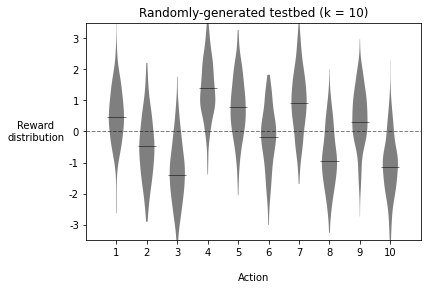

In [357]:
# instantiate testbed object
katb = KArmedTestBed(10)

# see what the underlying (latent) distributions look like
fig, ax = plt.subplots(figsize=(6,4))
katb.plot_reward_dists(ax=ax)
_ = ax.set_title(f'Randomly-generated testbed (k = {katb.k})')

In [403]:
from abc import ABC, abstractmethod
from typing import Optional

class Environment(ABC):
    """Abstract base class for k-armed bandit problem environments."""

    def __init__(self, k: int, baseline: float = 0.0):
        self._num_actions = k
        self._reward_means = self._generate_reward_means(baseline)
        self._opt_action = int(np.max(self._reward_means))

    @property
    def num_actions(self):
        """Getter for num_actions property."""
        return self._num_actions

    @property
    def opt_action(self):
        """Return the ground truth optimal action."""
        return self._opt_action


    def __call__(self, action: int):
        """Take an action and output a reward."""
        return self._action_to_reward(action=action)

    @abstractmethod
    def _action_to_reward(self, action: int):
        """Should house the actual mapping from action to reward."""
        pass

    def _generate_reward_means(self, baseline: float = 0.0):
        """Generate a set of k reward means from the unit normal dist.
        
        Args:
            baseline (float, optional): baseline reward to add to each
                randomly-generated reward value.

            Returns:
                float: (self.__k) draws from the unit normal dist.
        """
        return scipy.stats.norm(loc=0, scale=1).rvs(self.num_actions) + baseline


class KArmedTestBed(Environment):
    """General environment for the k-armed bandit problem,
    AKA the K-armed testbed.
    
    Should return rewards for actions taken, where rewards are
    stochastic.
    """
    def __init__(self, k: int, baseline: float = 0.0):
        super().__init__(k=k, baseline=baseline)
        self._reward_stds: np.ndarray = np.ones(k)


    def _action_to_reward(self, action: int):
        """Mapping from action to reward."""
        return self._reward_means[action] + self._reward_stds[action] * np.random.randn()

    
    def plot_reward_dists(self, ax: matplotlib.axes.Axes):
        """Plot the exact reward distributions of this environment."""
        for idx, rwm in enumerate(self._reward_means):
            y_p = scipy.stats.norm(loc=rwm, scale=1.).rvs(200)
            parts = ax.violinplot(
                y_p, 
                positions=[idx+1],
                showmeans=False,
                showextrema=False,
                points=500,
                )
            for pc in parts['bodies']:
                pc.set_facecolor('#000000')
                pc.set_alpha(.5)
            _width = 0.30
            ax.hlines(xmin=idx+1-_width, xmax=idx+1+_width, y=rwm, color='k', lw=.5)

        ax.plot([0,self.num_actions+1], [0, 0], color='k', linestyle='--', lw=1, alpha=0.5)
        ax.set(
            xlim=[0, self.num_actions+1],
            xticks=range(1, self.num_actions+1),
            xticklabels=[str(k) for k in range(1, self.num_actions + 1)],
            ylim=[-3.5,3.5],
            yticks=range(-3,4),
            yticklabels=[str(k) for k in range(-3, 4)],
            )
        ax.set_xlabel(xlabel='Action')
        ax.xaxis.set_label_coords(0.5, -0.15)
        ax.set_ylabel(ylabel='Reward\ndistribution', rotation=0) #, labelpad=35)
        ax.yaxis.set_label_coords(-0.15, 0.45)


# instantiate testbed object
env = KArmedTestBed(10)

# see what the underlying (latent) distributions look like
# fig, ax = plt.subplots(figsize=(6,4))
# env.plot_reward_dists(ax=ax)
# _ = ax.set_title(f'Randomly-generated testbed (k = {env.num_actions})')

env.num_actions
env(3)

1.9868862958991818

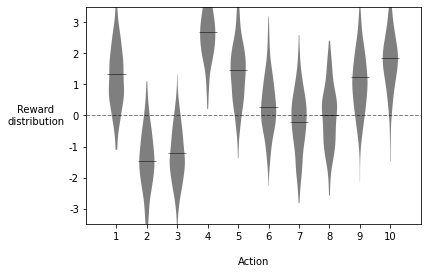

In [404]:
fig, ax = plt.subplots()
env.plot_reward_dists(ax)

In [ ]:
class BanditMethod():
    """Base class for solving the k-armed bandit problem via
    action-value estimation.

    - Uses epsilon-greedy method to select actions.
    - Updates action-value estimate using sample-averages.
    """

    def take_action(self, env: Environment):
        """Select an action, apply it to Environment, and return reward.

        Args:
            env (Environment): 

        Returns:
            action (int): index of action selected.
            reward (float): reward obtained by taking the selected action
                in the Environment env.
        """
        if np.random.rand() > self._epsilon: # greedy
            arg_maxes = np.argwhere(self._q == np.amax(self._q).flatten())
            action = np.random.choice(arg_maxes)
        else: # exploratory
            arg_nmaxes = np.argwhere(self._q != np.amax(self._q).flatten())
            if arg_nmaxes.size > 0:
                action = np.random.choice(arg_nmaxes)
            else: # if all are greedy, select random action
                action = np.random.choice(range(len(self._q)))
        self._n[action] += 1
        return action, env(action)


    def update_action_value(self,
        action_idx: int,
        reward: float,
        alpha: Optional[float] = None,
        ):
        """Update action-value estimates after taking an action and
        observing a reward. This will change for different bandit methods;
        the base implementation here is sample-averaging.

        Args:
            action_idx (int): 
            reward (float): 
            alpha (Optional[float], optional): _description_. Defaults to None.
        """
        if alpha:
            self._q[action_idx] += (reward - self._q[action_idx]) * alpha
        else:
            self._q[action_idx] += (reward - self._q[action_idx]) / self._n[action_idx]
        return

In [339]:
class EpsilonGreedy():
    """Learning is done by considering actions taken and rewards seen.
        There is an inherent time/state component to this.
    """
    def __init__(self, k: int, epsilon: float = 1.0):
        self.epsilon: float = epsilon # calls setter below
        if not (k > 0 and isinstance(k, int)):
            raise ValueError('k must be a positive integer!')
        self.__k: int = k
        self.__q = np.ones(k)  # initial action-values
        self.__n_selections = np.zeros(k)  # counts of actions selections
        self.__total_reward: float = 0

    @property
    def k(self):    
        return self.__k

    @staticmethod
    def _is_epsilon_valid(epsilon: float) -> None:
        """Raise ValueError if epsilon is invalid."""
        if not isinstance(epsilon, float):
            raise ValueError('epsilon must be a float!')
        if not (epsilon >= 0.0 and epsilon <= 1.0):
            raise ValueError('epsilon must be in the unit interval!')

    @property
    def epsilon(self):
        return self.__epsilon
    
    @epsilon.setter
    def epsilon(self, value: float):
        """Do input validation when setting epsilon."""
        self._is_epsilon_valid(value)
        self.__epsilon = value

    def _select_action(self, greedy: bool = False, verbose: bool = False):
        """Select an action.

        If greedy is set to True, selects randomly among greedy actions.
        If greedy is False, selects action by epsilon-greedy selection
        using self.__epsilon.

        Args:
            greedy (bool, optional): If True, override self.__epsilon and select
                a greedy action. Defaults to False.
            verbose (bool, optional): Log whether or not decision was made greedily.
                Defaults to False.

        Returns:
            action_idx (int): index for the selected action.
            greedy_flag (bool): True if action was selected greedily;
                False otherwise.
        """
        vprint = print if verbose else lambda x: None

        eps = 0.0 if greedy else self.epsilon

        # get the greedy actions
        actions_greedy = np.where(self.__q == self.__q.max())[0]
        actions_exploratory = np.where(self.__q != self.__q.max())[0]

        
        if (
            scipy.stats.uniform().rvs() >= eps or
            len(actions_exploratory) == 0 # all action-value ests are equal
            ): # greedy
            vprint('taking greedy action')
            return int(np.random.choice(actions_greedy)), True
        else: # exploratory
            vprint('taking exploratory action')
            return int(np.random.choice(actions_exploratory)), False


    def take_action(self, environment: KArmedTestBed, greedy: bool = False, verbose: bool = False):
        """Select an action, and take it, and perform the incremental
        action-value estimate update.

        Args:
            greedy (bool, optional): _description_. Defaults to False.
            verbose (bool, optional): _description_. Defaults to False.
        """
        # select an action
        action_idx, greedy = self._select_action(greedy=greedy, verbose=verbose)
        self.__n_selections[action_idx] += 1

        # take it; requires the environment
        reward = environment.take_action(action_idx=action_idx)
        self.__total_reward += reward

        # take it: perform the incremental update
        self.__q[action_idx] += (reward - self.__q[action_idx])/self.__n_selections[action_idx]

        # return action taken and greedy flag
        return action_idx, greedy, reward


    

k = 5
katb = KArmedTestBed(k=k)
eg = EpsilonGreedy(k=k, epsilon=0.01)
N = int(2e3)

q_init = eg._EpsilonGreedy__q.copy()

greedy_ct = 0
rewards = []
for n in range(N):
    action, greedy, reward = eg.take_action(
        environment=katb,
    )
    greedy_ct += int(greedy)
    rewards.append(reward)

q_fin = eg._EpsilonGreedy__q.copy()
print(f'Greedy action percentage: {greedy_ct / N:.2f}')
print('q_init  q_fin  q_actual')
for kk in range(k):
    print(f' {q_init[kk]:.2f}    {q_fin[kk]:.3f}   {katb._KArmedTestBed__reward_means[kk]:.3f}')

# N = 100
# gct = 0
# for n in range(N):
#     # gct += int(eg._select_action()[1])
# print(f'percentage of actions taken greedily: {gct}/{N}')
# # EpsilonGreedy(k=10, epsilon=0.8)._EpsilonGreedy__q


Greedy action percentage: 0.99
q_init  q_fin  q_actual
 1.00    -2.059   -1.947
 1.00    0.417   0.101
 1.00    0.081   0.015
 1.00    0.221   0.091
 1.00    0.504   0.516


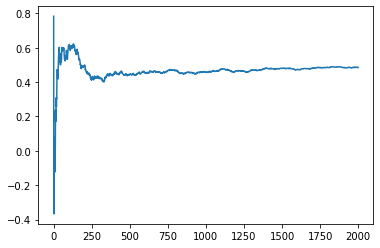

In [344]:
plt.plot(np.array(rewards).cumsum() / range(1, 1+len(rewards)))